In [1]:
# Importamos las librerías
from __future__ import absolute_import, division, print_function

import re
import string 

import nltk
import hdbscan
from joblib import Memory
import numpy as np
import pandas as pd
import seaborn as sns

from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs


import sklearn.datasets as data
import gensim.models.word2vec as w2v
import matplotlib.pyplot as plt

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Ruta del archivo CSV local
ruta_csv = "PARTIDAA.csv"

data = pd.read_csv(ruta_csv, encoding="latin1")

data.head()


,Nombre,Fecha,Texto
0,Director,"20/01/2021, 09:53",Los avatares de la vida os llevaron a todos a ...
1,Soren Ojoagudo,"21/01/2021, 11:53",De vez en cuando Soren se preguntaba qué demon...
2,Orsik Barbarroble,"21/01/2021, 13:24","Orsik siempre ha conocido la guerra, su padre ..."
3,Groac'h de fromma,"21/01/2021, 17:05",Groac'h era un enviado de su Sinagoga para par...
4,Gulgram Stonefist,"21/01/2021, 18:17",Justicia. Al final todo va en una misma direcc...


In [3]:

data["Texto"] = data["Texto"].astype(str)

# Ponemos en minúsculas
data["texto_limpio"] = data["Texto"].str.lower()
# Eliminamos acentos y otros símbolos
data["texto_limpio"] = data["texto_limpio"].apply(unidecode)
# Eliminamos números
data["texto_limpio"] = data["texto_limpio"].apply(lambda x: re.sub(r"\d+", " ", x))

In [4]:
# Eliminamos signos de puntuación
data["texto_limpio"] = data["texto_limpio"].str.translate(
    str.maketrans(string.punctuation, " " * len(string.punctuation))
)

In [5]:
# Eliminamos espacios innecesarios
data["texto_limpio"] = (
    data["texto_limpio"].str.replace(r"\s{2,}", " ", regex=True).str.strip()
)

In [6]:
# Eliminamos las stopwords
stop = stopwords.words("spanish")
data["texto_limpio"] = data["texto_limpio"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop)])
)



In [7]:
tokensrol = [list(texto.split()) for texto in data['texto_limpio']]

print(tokensrol)

[['avatares', 'vida', 'llevaron', 'combatir', 'invasiones', 'humanoides', 'montanas', 'lortmils', 'teniais', 'propias', 'motivaciones', 'enrolaros', 'diferentes', 'batallones', 'incursiones', 'destinadas', 'expulsar', 'humanoides', 'territorios', 'pertenecientes', 'ancestrales', 'clanes', 'enanos', 'varias', 'misiones', 'organizadas', 'coincidisteis', 'campo', 'batalla', 'disteis', 'cuenta', 'habilidades', 'compenetraban', 'casi', 'perfeccion', 'formasteis', 'especie', 'escuadron', 'especializado', 'misiones', 'mas', 'concretas', 'experiencia', 'campo', 'batalla', 'unisteis', 'proteger', 'diferentes', 'clanes', 'enanos', 'cierto', 'tiempo', 'gozasteis', 'cierta', 'fama', 'riqueza', 'hoy', 'parece', 'mas', 'siniestro', 'ano', 'comun', 'ac', 'malvados', 'cultistas', 'construyeron', 'capilla', 'cerca', 'pueblo', 'nulb', 'lugar', 'profano', 'atrajo', 'adoradores', 'bandidos', 'orcos', 'gnolls', 'indeseables', 'finalmente', 'cultistas', 'expandieron', 'estructuras', 'construir', 'conocido',

Modelo Word2Vec


In [8]:
rol2vec = w2v.Word2Vec(
    tokensrol,
    vector_size=50,  # Reducimos el tamaño del vector
    window=3,  # Marcamos el tamaño de la ventana de contexto
    min_count=1,  # Aceptamos palabras que aparecen al menos una vez
    workers=2,  # Usamos dos núcleos de CPU
)

In [9]:
rol2vec.save("small_word2vec_model.model")

In [10]:
def get_average_vector(words, rol2vec):
    vectors = [rol2vec.wv[word] for word in words if word in rol2vec.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(rol2vec.vector_size)

In [11]:
rol2vec.wv.most_similar("magia")

[('diera', 0.543352484703064),
 ('occhiverdi', 0.4714313745498657),
 ('peor', 0.4664127230644226),
 ('ruinas', 0.40496888756752014),
 ('ennegrecidos', 0.402576208114624),
 ('seguidme', 0.40173089504241943),
 ('tarde', 0.3998432457447052),
 ('obligara', 0.39843064546585083),
 ('tardando', 0.3983139395713806),
 ('escolteis', 0.39031699299812317)]

Añadir hdbscan:

In [12]:
# dialogue_vectors = [get_average_vector(dialogue, rol2vec) for dialogue in tokensrol] 
# dialogue_vectors = np.array(dialogue_vectors)

In [27]:
from hdbscan import HDBSCAN
clusterer = HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=40,memory=Memory(location=None),
    metric='euclidean', min_cluster_size=4, min_samples=15, p=None)

In [14]:
blobs, labels = make_blobs(n_samples=2000, centers=10, n_features=10)

In [15]:
print(clusterer)

HDBSCAN(gen_min_span_tree=True, min_samples=15)


In [16]:
rol2vector = rol2vec.wv.vectors
pd.DataFrame(rol2vector).head()



,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.002420,0.002160,0.009436,0.021090,-0.020767,-0.020941,0.019733,0.027816,-0.020945,-0.010457,...,-0.012442,0.009373,-0.016956,-0.006094,0.013243,0.000971,-0.018391,0.012721,0.015731,0.024860
1,-0.017902,0.009888,-0.009872,0.002884,0.014776,-0.015608,0.016420,-0.002898,-0.018941,0.015906,...,0.012018,-0.001665,0.006965,0.004243,0.033454,0.012052,-0.021436,-0.021983,0.007275,0.018642
2,-0.018280,0.008629,0.010331,0.013441,0.013990,-0.016718,0.006294,0.018111,-0.011919,-0.015425,...,0.019972,-0.014294,-0.018846,0.000657,0.001444,0.017562,0.010537,-0.006673,0.006179,0.007776
3,0.015682,-0.019234,-0.002340,0.009678,-0.004776,0.013120,0.024760,0.023279,-0.011703,0.014290,...,0.009039,-0.006146,0.005449,-0.013806,0.004648,0.005732,0.009727,-0.012467,-0.014745,0.013377
4,-0.000404,0.007322,-0.014763,-0.002072,0.014412,0.012947,-0.003748,0.010628,-0.022720,0.011502,...,-0.007325,0.002858,-0.003064,0.015092,0.015564,0.010313,0.002028,-0.009539,-0.006186,0.001201


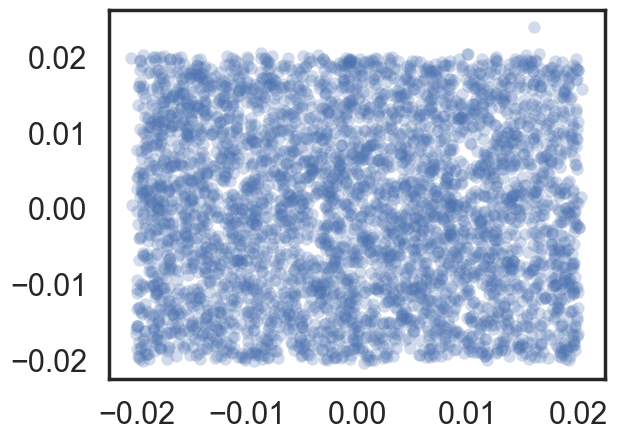

In [17]:
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.scatter(rol2vector[:, 0], rol2vector[:, 1], c='b', **plot_kwds)


In [29]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)

clusterer.fit_predict(rol2vec.wv.vectors)

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [19]:
clusterer.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [34]:
pd.crosstab(clusterer.labels_, columns='count')

col_0,count
row_0,
-1,4010
0,6
1,6
2,5
3,15
4,11


In [33]:
print(clusterer.labels_[3])

-1


In [22]:
clusterer.probabilities_

array([0., 0., 0., ..., 0., 0., 0.])

<Axes: ylabel='$\\lambda$ value'>

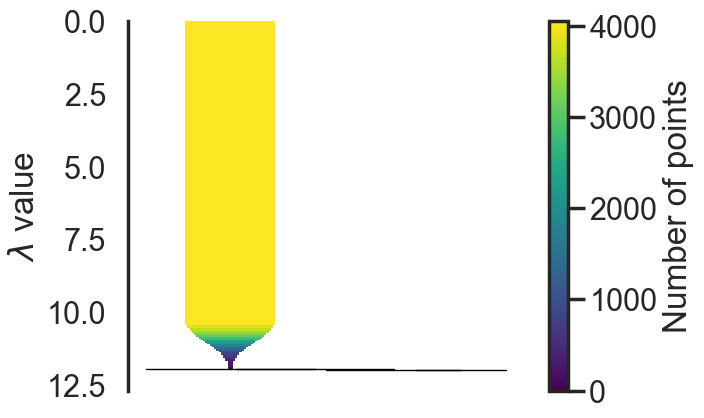

In [23]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

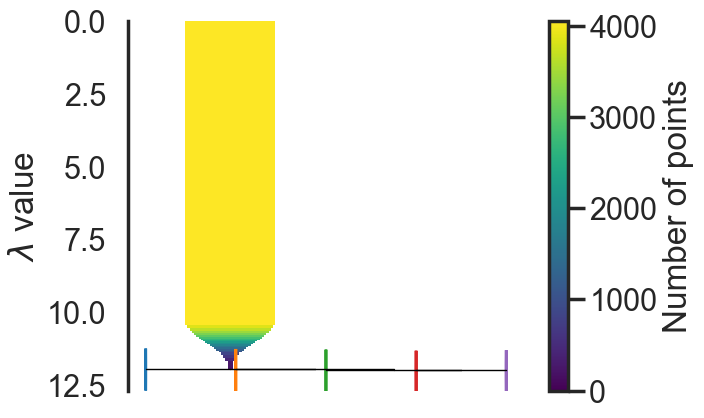

In [24]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [25]:
# %matplotlib inline  
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# plt.scatter(blobs[:, 0], blobs[:, 1], c=clusterer.labels_, **plot_kwds)

<Axes: >

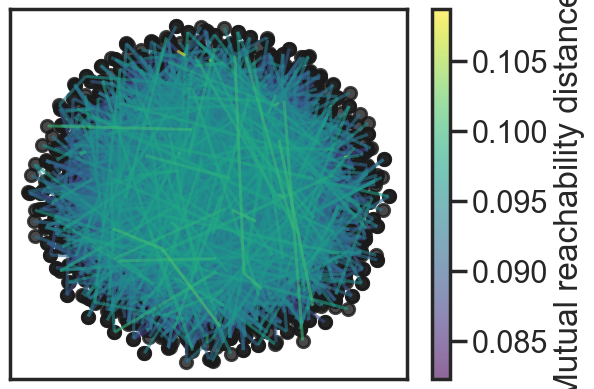

In [26]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)